### Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Generating Data

In [2]:
DIM = 2
NUM = 100

M1 = np.ones((DIM,))
M3 = 3*np.ones((DIM,))
M2 = 2 * np.ones((DIM,))

C1 = np.diag(0.2 * np.ones((DIM,)))
C2 = np.diag(0.15 * np.ones((DIM,)))
C3 = np.diag(0.15*np.ones((DIM,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

#NUM = 50
if __name__ == '__main__':
    # generate 50 points from gaussian 1
    x1 = generate_gaussian(M1, C1, NUM)
    x2 = generate_gaussian(M2, C2, NUM)
    x3 = generate_gaussian(M3, C3, NUM)
    # join
    x = np.concatenate((x1, x2, x3), axis = 0)
    # write
    #with open('gaussiandata.pickle', 'wb') as f:
    #    pickle.dump((x, y), f)

### Data Plotting

In [3]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

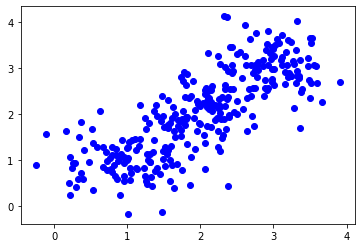

In [4]:
plt.plot(x[:,0],x[:,1],'bo')
plt.show()

### Auxiliary Functions

In [10]:
def euclidean_distance(x1,x2):
    return np.sqrt(np.sum(np.square(x1-x2)))
    
def kernel_value(dist,bw):
    val = np.exp(-0.5*np.square(float(dist/bw)))
    val = val/(bw*np.sqrt(2*np.pi))
    return val

def neighbours(X,xi,dist = 5):
    valid_pts = []
    for x in X:
        dist_x2xi = euclidean_distance(x,xi)
        if dist_x2xi < dist:
            valid_pts.append(x)
    return valid_pts

def DBIndex(x,y):
    unique_y = np.unique(y)
    mu = []
    S = []
    d = np.zeros((len(unique_y),len(unique_y)))
    for yi in unique_y:
        x_sub = x[(y == yi).reshape([-1])]
        mu.append(np.mean(x_sub))
        S.append(np.sum(x_sub-mu[-1])/float(x_sub.shape[0]))
    for i in range(len(unique_y)):
        for j in range(len(unique_y)):
            d[i][j] = mu[i]-mu[j]
    
    #print(d)
    R = []
    tempR = []
    for i in range(len(unique_y)):
        for j in range(len(unique_y)):
            if i!=j:
                tempR.append((S[i]+S[j])/d[i][j])
        R.append(np.max(tempR))
    
    return np.sum(R)/len(R)

### Calculating the Cluster Labels 

In [11]:
def get_labels(x,past_x):
    unique_x = np.unique(np.around(past_x,decimals=5),axis=0)
    #print(unique_x)
    y = np.zeros(past_x.shape[0])
    for i in range(unique_x.shape[0]):
        distances = np.sqrt(np.sum(np.square(unique_x-unique_x[i]),axis=1))
        unique_x[distances < 0.01] = unique_x[i]
    #print(np.unique(unique_x,axis=0))
    unique_x = np.unique(unique_x,axis=0)
    for i in range(unique_x.shape[0]):
        distances = np.sqrt(np.sum(np.square(past_x-unique_x[i]),axis=1))
        y[distances < 0.01] = i
    #print(np.unique(y))
    return y

### Computing clusters with minimum DB Index value

In [28]:
x_copy = np.copy(x)

past_x = []
n_iter = 10

bd = np.linspace(0.5,2,num=5)

boundary_dist = bd*(C1[0][0]+C2[0][0]+C3[0][0])
optimal_bd = 0

b = np.linspace(0.5,1.5,num=5)

bandwidth = b*(C1[0][0]+C2[0][0]+C3[0][0])

dbind = None

for boun_dist in boundary_dist:
    for bwidth in bandwidth:
        prev_dbind = dbind
        temp_past_x = []
        for it in range(n_iter):
            for i,xs in enumerate(x_copy):
                neighbours_xs = neighbours(x_copy,xs,boun_dist)
                weight = np.array([kernel_value(euclidean_distance(neighbour,xs),bwidth) for neighbour in neighbours_xs]).reshape([-1,1]) 
                num = np.sum(np.multiply(weight,neighbours_xs),axis=0)
                den = np.sum(weight)
                x_copy[i] = num/den
            temp_past_x.append(np.copy(x_copy))
            
        temp_dbind = DBIndex(x,get_labels(x,temp_past_x[-1]))
        
        if dbind != None and prev_dbind != None and temp_dbind < prev_dbind:
            dbind = temp_dbind
            past_x = temp_past_x
            optimal_bd = boun_dist
            optimal_bw = bwidth
        elif prev_dbind == None:
            dbind = temp_dbind
            past_x = temp_past_x
            optimal_bd = boun_dist
            optimal_bw = bwidth
print("Optimal Boundary Distance : ",optimal_bd)
print("Optimal Bandwidth : ",optimal_bw)

Optimal Boundary Distance :  1.0
Optimal Bandwidth :  0.375


### Getting the final labels

In [29]:
min_dbindex = np.argmin(dbind)
y = get_labels(x,past_x[-1])

### Plotting the Mean Shifting Process

In [30]:
import matplotlib.animation as animation
import matplotlib
matplotlib.use('Agg')
from matplotlib.animation import PillowWriter
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(
            self._outfile, save_all=True, append_images=self._frames[1:],
            duration=int(1000 / self.fps), loop=0)

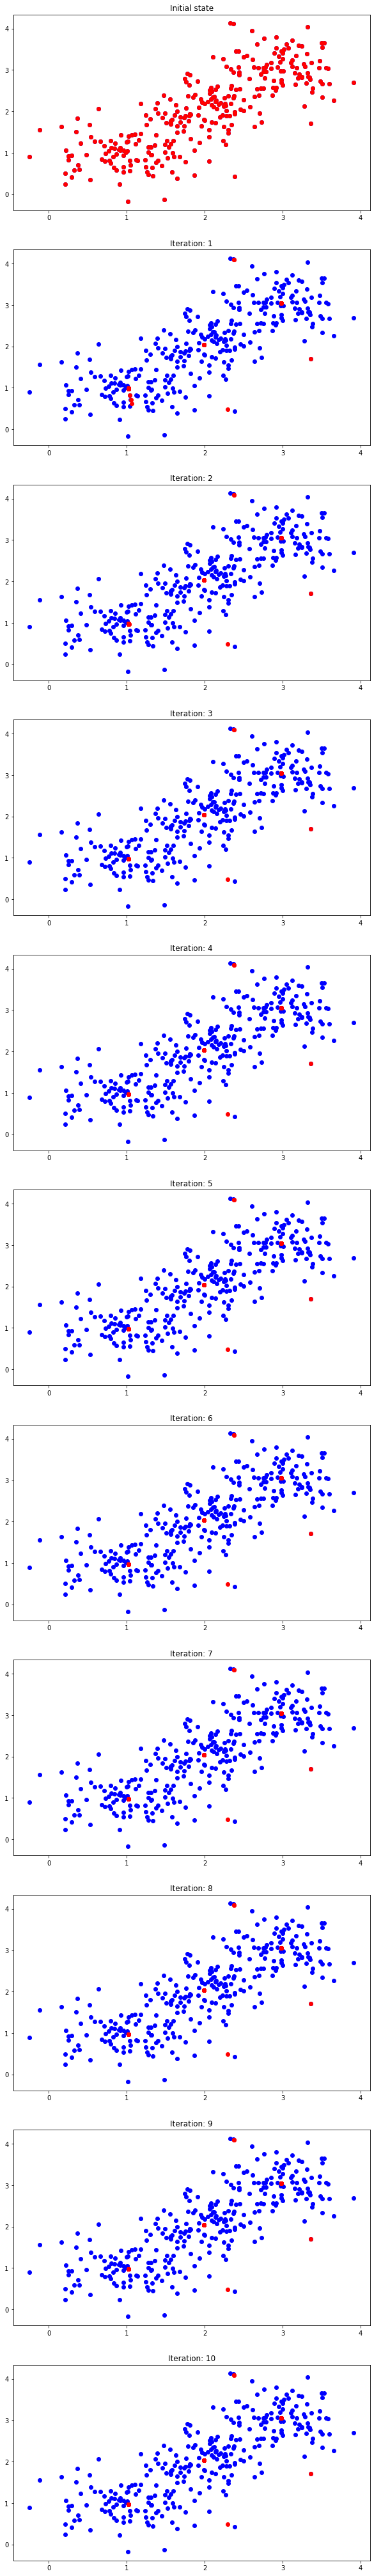

In [31]:
%matplotlib inline
figure = plt.figure(1)
figure.set_size_inches((10, 80))
plt.subplot(n_iter + 2, 1, 1)
plt.title('Initial state')
plt.plot(x[:,0], x[:,1], 'bo')
plt.plot(x[:,0], x[:,1], 'ro')
ims = []
for i in range(n_iter):
    figure_index = i + 2
    plt.subplot(n_iter + 2, 1, figure_index)
    plt.title('Iteration: %d' % (figure_index - 1))
    plt.plot(x[:,0], x[:,1], 'bo')
    plt.plot(past_x[i][:,0], past_x[i][:,1], 'ro')

#ani = animation.ArtistAnimation(figure, ims, interval=50, blit=True,repeat_delay=1000)
#ani.save('msc.gif',writer=LoopingPillowWriter(fps=10))

### Plotting the final clusters

In [39]:
COLORS = ['g','r','pink','magenta','y','b','c','k','m']*5

In [40]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    #print(unique)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

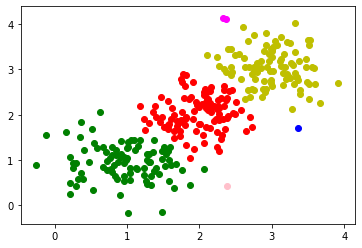

In [41]:
plot_data_with_labels(x,y.astype('int').reshape([-1]))

### sklearn Comparison

In [35]:
from sklearn import cluster

cls = cluster.MeanShift()
clusters = cls.fit(x)

In [36]:
cluster.estimate_bandwidth(x)

0.9640041043396502

In [37]:
y_sk = clusters.labels_

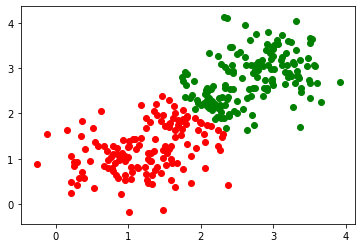

In [42]:
plot_data_with_labels(x,y_sk)

#### Actual number of clusters = 3
#### sklearn output contains 2 clusters
#### My output contains 3 large clusters